# CO31 - The Structure of White Dwarf Stars
Calum Holker

In [411]:
from format_labels import format_label_string_with_exponent
import scipy.constants as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import make_interp_spline, BSpline

## Solve ODE Problem
dy/dt = f(y,t) using a Runge-Kutta algorithm

Input:

        f - a function that receives the current state, y, and the current position and returns the derivative value of the statement, dy/dr

        y0 - the initial state of the system, given in a column matrix (Mx1)

        r - vector of position steps with length N where the values of y will be returned

Output:
        
        y - (MxN) matrix that contains the values of y at every position/time step. Columns correspond to the position/time and rows to the element of y

In [349]:
def ode_solve_rk(f, y0, r):
    y0 = np.array(y0)
    y = np.zeros((len(y0), len(r)))
    for i, ri in enumerate(r):
        dr = ri if i==0 else (r[i]-r[i-1])
        f0 = f(y0, ri)
        f1 = f((y0 + f0*(dr/2)), ri)
        f2 = f((y0 + f1*(dr/2)), ri)
        f3 = f((y0 + f2*dr), ri)
        y4 = y0 + ((f0 + 2*f1 + 2*f2 + f3) * (dr/6))
        y[:,i] = y4
        y0 = y4
    return y

## Density and Mass Solver
Obtains the density as a function of the radial distance using the ODE solver and the non-relativistic equation

Input:

        rho0 - the central density at r = 0

        r - the grid points of radial distance where the density is calculated in the form of a vector with N elements

        rel - boolean distinguishing relativistic and non-relativistic cases

Output:

        rho - an N-element vector that contains the density at the radial grid points given in r

        mass - an N-element vector of teh cumulative mass of the white dwarf star from r=0 to the radial grid point given in r


In [350]:
def get_density(rho0, r, rel=False):
    dr = r[0]
    m0 = (4/3)*sc.pi*(dr**3)*rho0
    y0 = [rho0, m0]
    if rel == False:
        y = ode_solve_rk(DyDr, y0, r)
    else:
        y = ode_solve_rk(DyDr_rel, y0, r)
    rho = y[0,:]
    mass = y[1,:]
    return(rho, mass)

In [351]:
def DyDr(y, r):
    dydr = []
    dPdp = (((sc.h**2)*(2**(1/3)))/(48*sc.electron_mass*(sc.proton_mass**(5/3))))*(((3*y[0])/(sc.pi))**(2/3))
    dpdr = (-1 * (1/dPdp) * ((sc.G*y[0]*y[1])/(r**2)))
    dydr.append(dpdr)
    dmdr = (4 * sc.pi * (r**2) * y[0])
    dydr.append(dmdr)
    dydr = np.array(dydr)
    return dydr

In [352]:
def DyDr_rel(y, r):
    dydr = []

    A = (8 * sc.pi * (sc.electron_mass**4) * (sc.c**5))/(3 * (sc.h**3))
    Pf = ((3 * (sc.h**3) * y[0])/(16 * sc.pi * sc.proton_mass))**(1/3)
    a = np.arcsinh(Pf/(sc.electron_mass*sc.c))
    dPda = A * (np.sinh(a)**4)
    dadPf = ((Pf**2)+((sc.electron_mass*sc.c)**2))**(-1/2)
    dPfdp = (((3 * (sc.h**3))/(16 * sc.pi * sc.proton_mass))**(1/3)) * (1/3) * (y[0]**(-2/3))
    dPdp = dPda * dadPf * dPfdp

    dpdr = (-1/dPdp) * ((sc.G * y[0] * y[1])/(r**2))
    dydr.append(dpdr)
    
    dmdr = 4 * sc.pi * (r**2) * y[0]
    dydr.append(dmdr)
    dydr = np.array(dydr)
    return dydr

In [390]:
rho0 = 1e13
r = np.logspace(-1, 3.5 , 1000, base=100)
rho, mass = get_density(rho0, r)

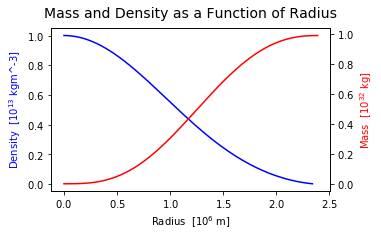

In [391]:
plt.rc('xtick',labelsize = 10)
plt.rc('ytick',labelsize = 10)
fig, ax = plt.subplots(figsize=(5,3))
ax.set_title('Mass and Density as a Function of Radius', pad=10, fontsize=14)
ax.ticklabel_format(style='sci', scilimits=(0,0))

ax.plot(r, rho, color='blue')

ax.set_xlabel('Radius [m]', fontsize=10)
ax.set_ylabel("Density [kgm^-3]", color='blue', fontsize=10)
format_label_string_with_exponent(ax, axis = 'both')
ax2 = ax.twinx()

ax2.plot(r, mass, color='red')

ax2.set_ylabel('Mass [kg]', color='red', fontsize=10)
format_label_string_with_exponent(ax2, axis = 'y')

In [392]:
Outer_radius = r[np.argmax(rho<(0.005*rho0))-1]
Total_mass = mass[np.argmax(rho<(0.005*rho0))-1]
print(Outer_radius, Total_mass)

2292769.312865649 9.869857583593408e+31


In [406]:
rho0 = np.logspace(6, 14, 1000)
r = np.logspace(-1, 4 , 1000, base=100)
rad = []
total_mass = []
for r0 in rho0:
    rho, mass = get_density(r0, r, rel=False)
    rad.append(r[np.argmax(rho<(0.005*r0))-1])
    total_mass.append(mass[np.argmax(rho<(0.005*r0))-1])

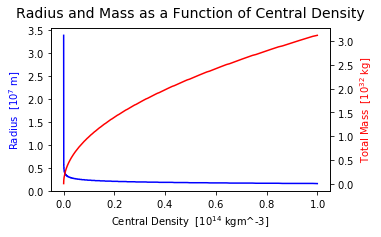

In [407]:
plt.rc('xtick',labelsize = 10)
plt.rc('ytick',labelsize = 10)
fig, ax = plt.subplots(figsize=(5,3))
ax.set_title('Radius and Mass as a Function of Central Density', pad=10, fontsize=14)
ax.ticklabel_format(style='sci', scilimits=(0,0))

ax.plot(rho0, rad, color='blue')

ax.set_xlabel('Central Density [kgm^-3]', fontsize=10)
ax.set_ylabel("Radius [m]", color='blue', fontsize=10)
format_label_string_with_exponent(ax, axis = 'both')
ax2 = ax.twinx()

ax2.plot(rho0, total_mass, color='red')

ax2.set_ylabel('Total Mass [kg]', color='red', fontsize=10)
format_label_string_with_exponent(ax2, axis = 'y')

In [408]:
rho0 = np.logspace(6, 14, 1000)
r = np.logspace(-1, 4, 1000, base=100)
rad_rel = []
total_mass_rel = []
for r0 in rho0:
    rho, mass = get_density(r0, r, rel=True)
    rad_rel.append(r[np.argmax(rho<(0.005*r0))-1])
    total_mass_rel.append(mass[np.argmax(rho<(0.005*r0))-1])

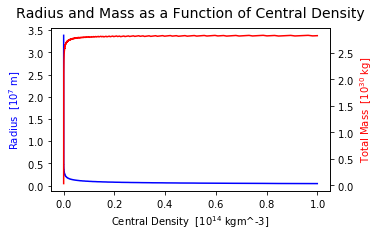

In [409]:
plt.rc('xtick',labelsize = 10)
plt.rc('ytick',labelsize = 10)
fig, ax = plt.subplots(figsize=(5,3))
ax.set_title('Radius and Mass as a Function of Central Density', pad=10, fontsize=14)
ax.ticklabel_format(style='sci', scilimits=(0,0))

ax.plot(rho0, rad_rel, color='blue')

ax.set_xlabel('Central Density [kgm^-3]', fontsize=10)
ax.set_ylabel("Radius [m]", color='blue', fontsize=10)
format_label_string_with_exponent(ax, axis = 'both')
ax2 = ax.twinx()

ax2.plot(rho0, total_mass_rel, color='red')

ax2.set_ylabel('Total Mass [kg]', color='red', fontsize=10)
format_label_string_with_exponent(ax2, axis = 'y')

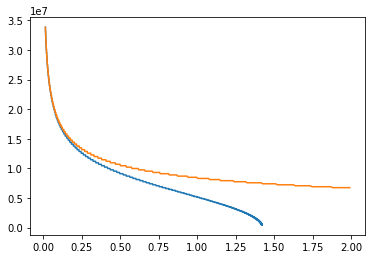

In [435]:
tmr = np.array([x/(1.989*(10**30)) for x in total_mass_rel])
tmr_s = tmr[tmr < 2]
rr = np.array([x for x in rad_rel])
rr_s = rr[tmr < 2]
tm = np.array([x/(1.989*(10**30)) for x in total_mass])
tm_s = tm[tm < 2]
r = np.array([x for x in rad])
r_s = r[tm < 2]

plt.plot(tmr_s, rr_s)
plt.plot(tm_s, r_s)

In [436]:
print(tmr[-1])

1.4203515119859456
